In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.utils import check_array
from sklearn.base import clone
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
SEED = 90
N_FOLDS = 5
TARGET = 'Response'

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
original = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv', index_col='id')

In [4]:
train = pd.concat([train, original]).reset_index(drop=True) 
train = train.drop_duplicates(keep="last").reset_index(drop=True)

In [5]:
X = train.drop(columns=TARGET)
y = train[TARGET]

In [6]:
def get_scores(oof_pred_probs):
    scores = []
    skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        scores.append(score)
    return scores

In [7]:
test_pred_probs = {}
oof_pred_probs = {}
scores = {}

In [8]:
xgb_oof_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/xgboost/xgb_oof_pred_probs_*.pkl')
xgb_test_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/xgboost/xgb_test_pred_probs_*.pkl')

xgb_oof_pred_probs = pickle.load(open(xgb_oof_pred_probs_files[0], 'rb'))
xgb_test_pred_probs = pickle.load(open(xgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
scores['XGBoost'] = get_scores(xgb_oof_pred_probs)

In [9]:
lgbm_oof_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/lightgbm/lgbm_oof_pred_probs_*.pkl')
lgbm_test_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/lightgbm/lgbm_test_pred_probs_*.pkl')

lgbm_oof_pred_probs = pickle.load(open(lgbm_oof_pred_probs_files[0], 'rb'))
lgbm_test_pred_probs = pickle.load(open(lgbm_test_pred_probs_files[0], 'rb'))

oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
scores['LightGBM'] = get_scores(lgbm_oof_pred_probs)

In [10]:
catboost_oof_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/catboost/catboost_oof_pred_probs_*.pkl')
catboost_test_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/catboost/catboost_test_pred_probs_*.pkl')

catboost_oof_pred_probs = pickle.load(open(catboost_oof_pred_probs_files[0], 'rb'))
catboost_test_pred_probs = pickle.load(open(catboost_test_pred_probs_files[0], 'rb'))

oof_pred_probs['CatBoost'] = catboost_oof_pred_probs
test_pred_probs['CatBoost'] = catboost_test_pred_probs
scores['CatBoost'] = get_scores(catboost_oof_pred_probs)

In [11]:
ann_oof_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/keras/keras_oof_pred_probs_*.pkl')
ann_test_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/keras/keras_test_pred_probs_*.pkl')

ann_oof_pred_probs = pickle.load(open(ann_oof_pred_probs_files[0], 'rb'))
ann_test_pred_probs = pickle.load(open(ann_test_pred_probs_files[0], 'rb'))

oof_pred_probs['KerasANN'] = ann_oof_pred_probs
test_pred_probs['KerasANN'] = ann_test_pred_probs
scores['KerasANN'] = get_scores(ann_oof_pred_probs)

In [12]:
lr_oof_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/logistic-regression/logisticregression_oof_pred_probs_*.pkl')
lr_test_pred_probs_files = glob.glob('/kaggle/input/insurance-cross-selling-oof-files/logistic-regression/logisticregression_test_pred_probs_*.pkl')

lr_oof_pred_probs = pickle.load(open(lr_oof_pred_probs_files[0], 'rb'))
lr_test_pred_probs = pickle.load(open(lr_test_pred_probs_files[0], 'rb'))

oof_pred_probs['LogisticRegression'] = lr_oof_pred_probs
test_pred_probs['LogisticRegression'] = lr_test_pred_probs
scores['LogisticRegression'] = get_scores(lr_oof_pred_probs)

In [13]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}')
        
        scores = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)    
            oof_pred_probs[val_idx] = y_pred_probs          
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            del model
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.5f}')
            
        print(f'------ Average AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}')
        
        self._save_submission(test_pred_probs, np.mean(scores))
        
        return oof_pred_probs, scores
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        sub['id'] = sub['id']
        sub[TARGET] = test_pred_probs[:, 1]
        # Referencee https://www.kaggle.com/code/paddykb/a-glitch-in-the-insurance-matrix
        INPUT_DIR = Path('/kaggle/input/playground-series-s4e7')
        train_data = pd.read_csv(INPUT_DIR / 'train.csv')
        test_data = pd.read_csv(INPUT_DIR / 'test.csv')
        orig_data = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
        features = sorted(set(test_data.columns) - set(['id']))
        train_data.merge(orig_data, on=features).filter(['Response_x', 'Response_y']).value_counts().reset_index()
        override_sub = test_data.merge(orig_data.drop(columns=['id']), on=features).assign(override=lambda x: np.where(x['Response'] == 0, 1, 0)).filter(['id', 'override']).groupby(['id'], as_index=False).agg(override=('override', 'mean'))
        sub.merge(override_sub, how='outer').assign(Response=lambda x: np.where(x['override'].isna(), x['Response'], x['override'])).filter(['id', 'Response']).to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [14]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2851035
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]

estimators = [
    ('XGBoost',             PassThroughClassifier(list(range(0, 2)))),
    ('LightGBM',            PassThroughClassifier(list(range(2, 4)))),
    ('CatBoost',            PassThroughClassifier(list(range(4, 6)))),
    ('KerasANN',            PassThroughClassifier(list(range(6, 8)))),
    ('LogisticRegression',  PassThroughClassifier(list(range(8, 10)))),
]

In [15]:
X_train = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

In [16]:
stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
stacking_trainer = Trainer(stacking_model)
stacking_oof_pred_probs, stacking_scores = stacking_trainer.fit_predict(X_train, y, X_test)
scores['Stacking'] = stacking_scores

Training StackingClassifier
--- Fold 1 - AUC: 0.89572
--- Fold 2 - AUC: 0.89563
--- Fold 3 - AUC: 0.89569
--- Fold 4 - AUC: 0.89583
--- Fold 5 - AUC: 0.89596
------ Average AUC: 0.89577 ± 0.00012


In [17]:
scores = pd.DataFrame(scores)
scores

,XGBoost,LightGBM,CatBoost,KerasANN,LogisticRegression,Stacking
0,0.891549,0.892316,0.895341,0.888478,0.882333,0.895717
1,0.891598,0.892281,0.895218,0.888378,0.882299,0.895631
2,0.891614,0.892207,0.895334,0.888448,0.882276,0.895693
3,0.891695,0.892395,0.895466,0.888715,0.882529,0.895832
4,0.891742,0.892564,0.895595,0.888726,0.882537,0.895958


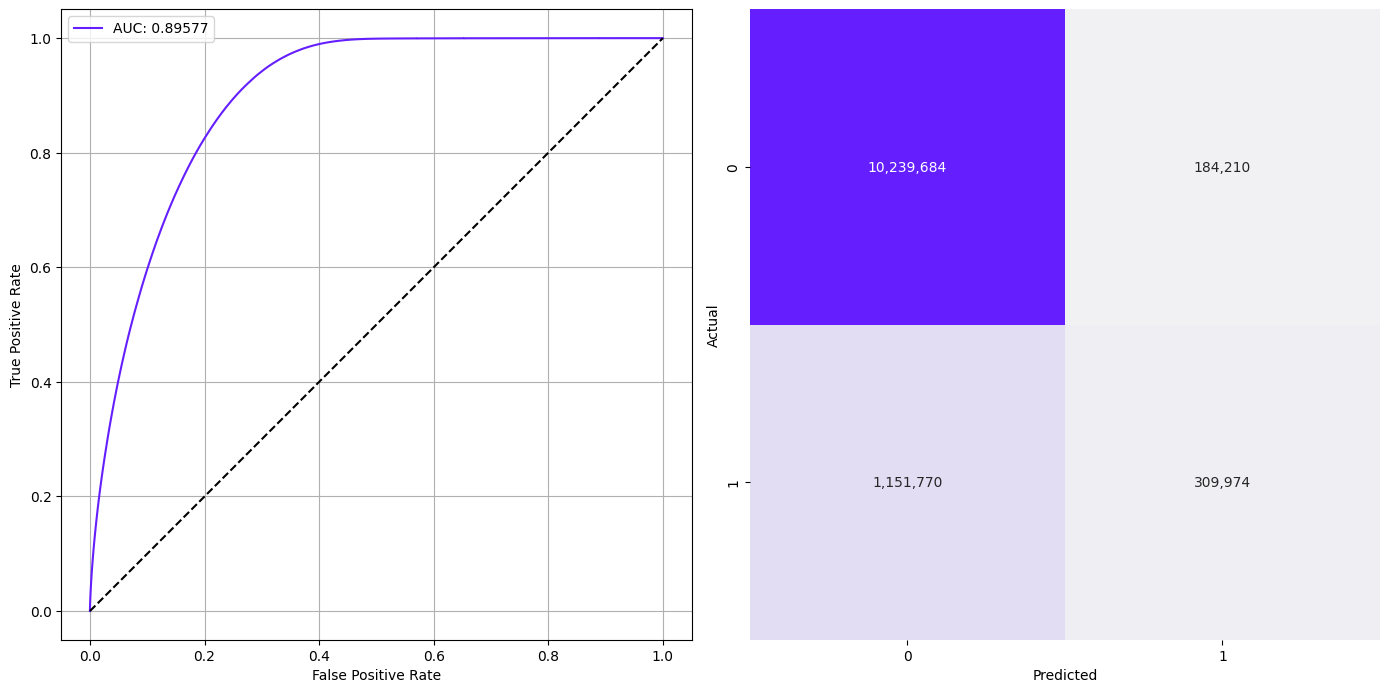

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, stacking_oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(stacking_scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = stacking_oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

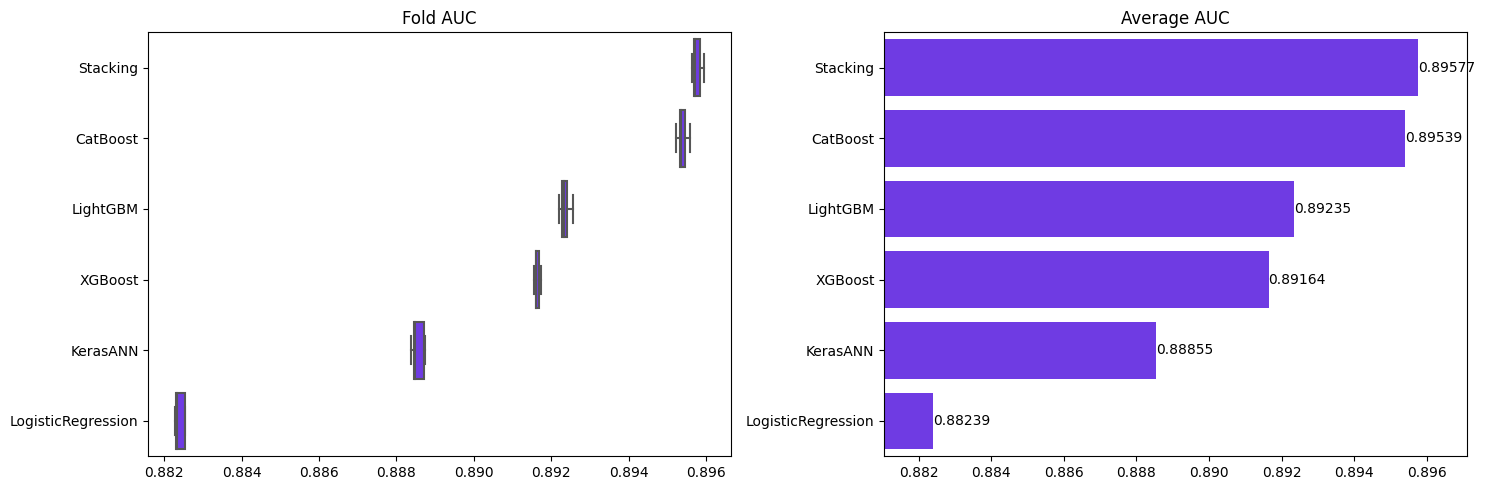

In [19]:
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.1
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 5), va='center')

plt.tight_layout()
plt.show()